In [109]:
import tensorflow as tf
import tensorflow.keras as keras
tf.random.set_seed(777)
import numpy as np
import matplotlib.pyplot as plt
from guaranteed_control.problems.pendulum import *
from guaranteed_control.problems.mountain_car import *
from guaranteed_control.intervals.interval import Interval
import tqdm
import gym
from guaranteed_control.ddpg.ddpg import DDPG, play, train
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_3d(env, actor, N=1000, pendulum=False):
    high = env.observation_space.high
    low = env.observation_space.low
    N = 500

    X, Y = np.meshgrid(np.linspace(low[0], high[0], N), np.linspace(low[1], high[1], N))

    H = np.concatenate([X.reshape((-1, 1)), Y.reshape(-1, 1)], axis=1)

    if pendulum:
        X_cos, X_sin = np.cos(H[:,0]).reshape(-1, 1), np.sin(H[:, 0]).reshape(-1, 1)
        actions = agent.actor(np.concatenate([X_cos, X_sin, H[:,1].reshape(-1, 1)], axis=1))

    else:
        actions = agent.actor(H)

    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, actions.numpy().reshape(N, N))
    ax.set_xlabel('x: position')
    ax.set_ylabel('y: speed')
    ax.set_zlabel('z: action')

    plt.show()

In [7]:
#OU noise!!!!

with tf.device('/cpu:0'):
    env = Pendulum()
    env.reset()
    agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16, batch_size=16, noise_std=0.05, epsilon_s=0.05, lambda_smooth=0.2, D_s=10)
    input_interval = Interval(interval=[[np.pi,np.pi+0.01], [1, 1+0.01]])
    low, high = input_interval.high_low()
    agent.start_training(env, agent, input_interval=input_interval, n_episodes=400)

In [7]:
#OU noise!!!!

with tf.device('/cpu:0'):
    env = MountainCar()
    env.reset()
    agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16, batch_size=16, noise_std=0.4, epsilon_s=0.05, lambda_smooth=0, D_s=10)
    input_interval = Interval(interval=[[-0.6, -0.4], [-0.07, 0.07]])
    low, high = input_interval.high_low()
    agent.start_training(env, agent, input_interval=input_interval, n_episodes=600)

In [4]:
keras.models.save_model(agent.actor, filepath="./models/car_smooth_actor.tf", save_format="tf")
# keras.models.save_model(agent.critic, filepath="./models/pendulum_smooth_critic.tf", save_format="tf")

INFO:tensorflow:Assets written to: ./models/car_smooth_actor.tf\assets


c:\Users\ramla\anaconda3\envs\tf27\lib\site-packages\keras\layers\core\lambda_layer.py:297: UserWarning: ddpg is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


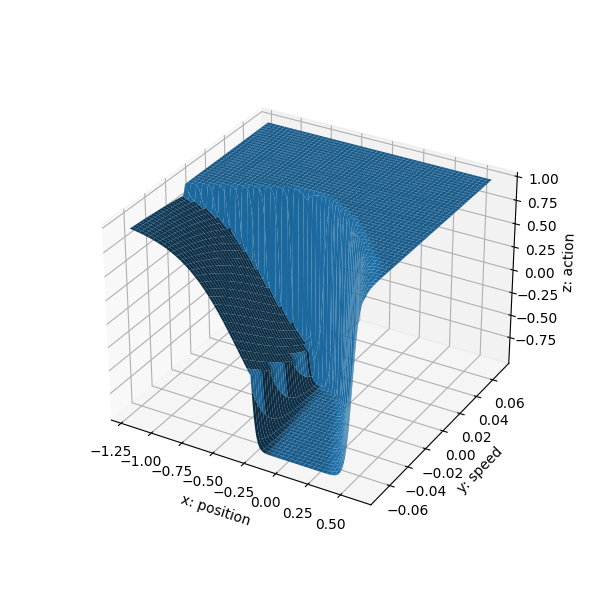

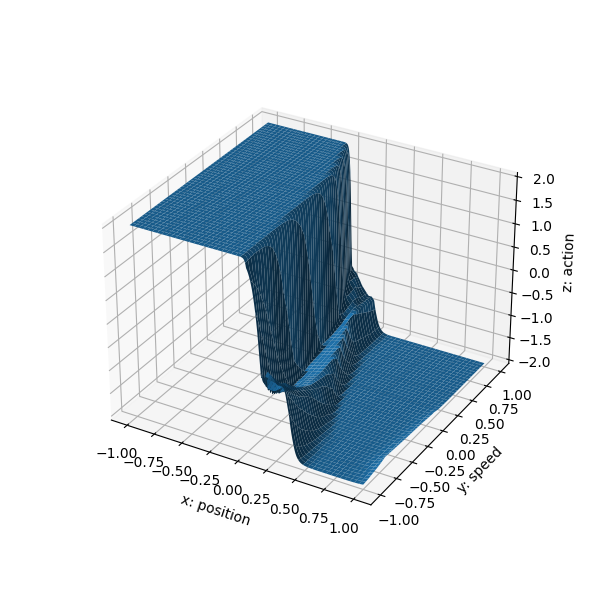

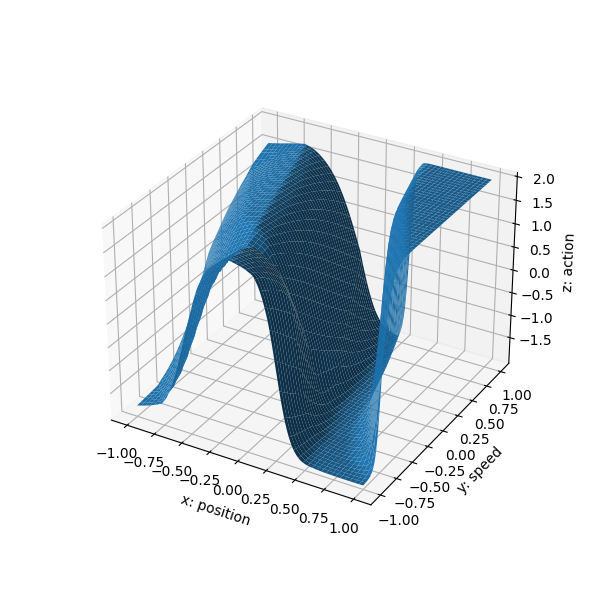

In [4]:
%matplotlib widget

env = MountainCar()
env.reset()
agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16, batch_size=16, noise_std=0.4, epsilon_s=0.05, lambda_smooth=0, D_s=10)
agent.actor = keras.models.load_model("./models/car_smooth_actor.tf")
plot_3d(env, agent.actor, N=2000, pendulum=False)

env = Pendulum()
env.reset()
agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16, batch_size=16, noise_std=0.4, epsilon_s=0.05, lambda_smooth=0, D_s=10)
agent.actor = keras.models.load_model("./models/pendulum_actor_16_small_interval.tf")
plot_3d(env, agent.actor, N=2000, pendulum=True)

env = Pendulum()
env.reset()
agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16, batch_size=16, noise_std=0.1, epsilon_s=0.05, lambda_smooth=0.2, D_s=10)
agent.actor = keras.models.load_model("./models/pendulum_smooth_actor.tf")
plot_3d(env, agent.actor, N=2000, pendulum=True)

[-2.61700952 -0.33753091]
[0.29653706 0.80590189]


c:\Users\ramla\anaconda3\envs\tf27\lib\site-packages\keras\layers\core\lambda_layer.py:297: UserWarning: ddpg is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Episode 0 finished with reward: -336.3414128296157
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89

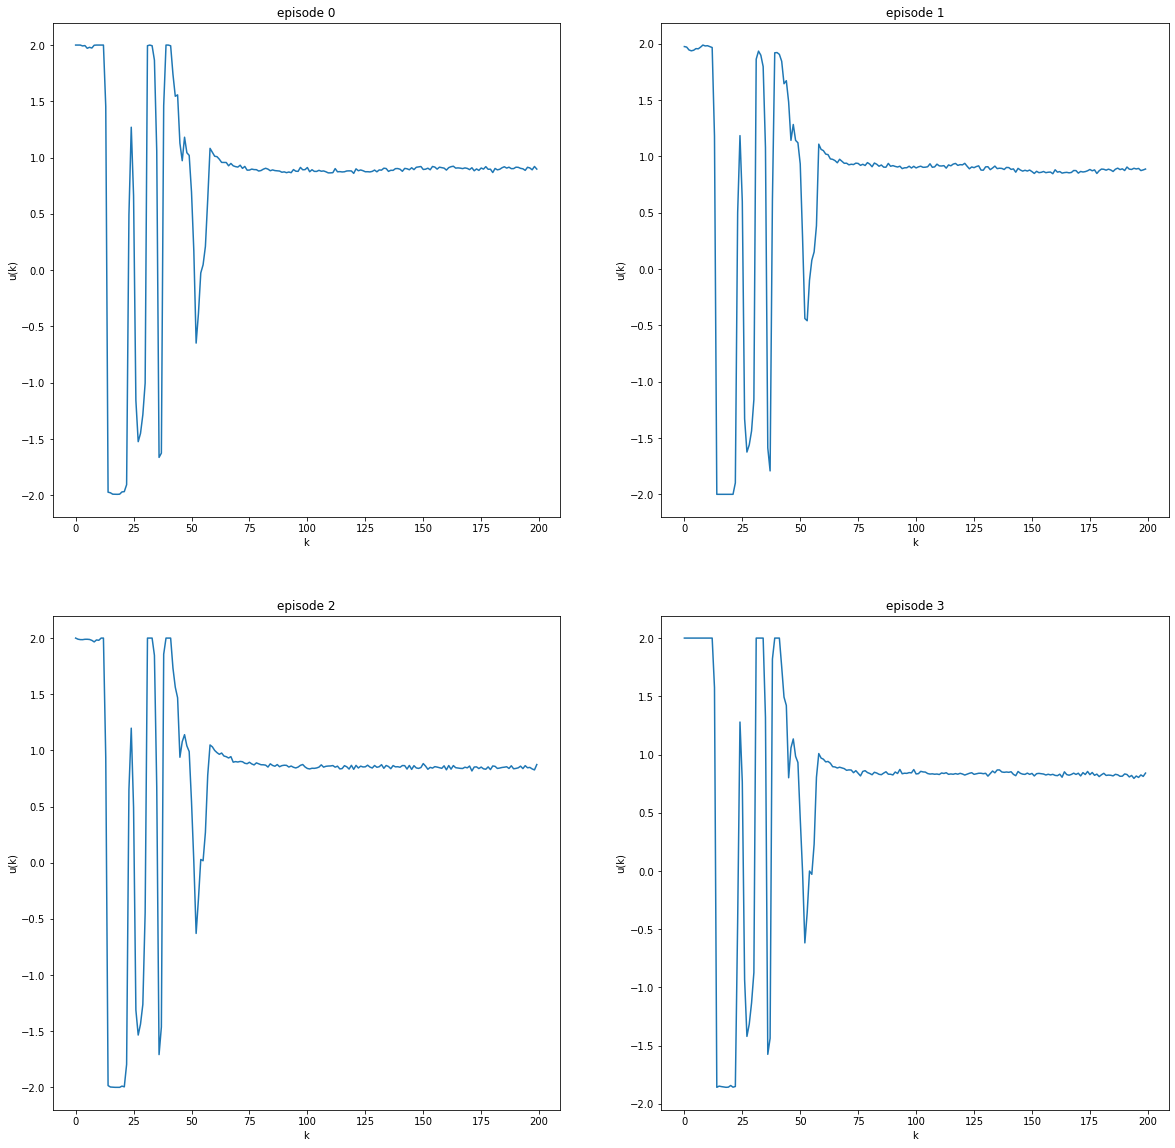

In [167]:
%matplotlib inline
with tf.device("/cpu:0"):
    env = pendulum()
    print(env.unwrapped.state)
    env.reset()
    print(env.state)
    agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16, batch_size=16, noise_std=0.1, epsilon_s=0.05, lambda_smooth=0.2, D_s=10)
    agent.actor = keras.models.load_model("./models/pendulum_smooth_actor3.tf")
    input_interval = Interval(interval=[[np.pi,np.pi+0.01], [1, 1+0.01]])
    eps_rewards, observations, actions = play(env, agent, n_games= 4, input_interval=input_interval, plot=True, watch=False)

In [26]:
env = Pendulum()
print(env.done)

AttributeError: 'Pendulum' object has no attribute 'done'

In [ ]:
def success(observation, epsilon=1e-1):
    observation = np.array(observation)
    if np.sum(np.abs(observation[-40:, 0] - np.ones(40)) > epsilon) != 0:
        return False
    return True

def success_rate(observations):
    failures = []

    for i,observation in enumerate(observations): 
        if not(success(observation)):
            failures.append(i)

    return failures, 1 - len(failures)/len(observations)

In [103]:
failures, s_rate = success_rate(observations)
failures, s_rate

([], 1.0)

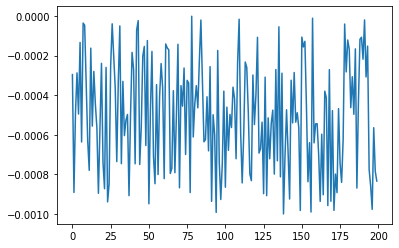

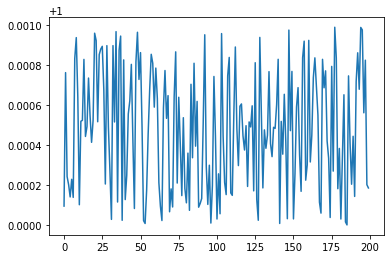

In [95]:
plt.plot([observations[i][0][0] for i in range(len(observations))])
plt.show()
plt.plot([observations[i][0][2] for i in range(len(observations))])
plt.show()

In [96]:
n = int(np.floor(np.sqrt(len(failures))))
fig, axs = plt.subplots(n+1, n, figsize=(15, 15))
for i, failure in enumerate(failures):
    axs[i//n][i%n].plot(np.array(actions[failure])[:,0], linewidth=1)
    axs[i//n][i%n].set_xlabel("k")
    axs[i//n][i%n].set_xlabel("u(k)")

plt.show()

fig, axs = plt.subplots(n+1, n, figsize=(15, 15))
for i, failure in enumerate(failures):
    axs[i//n][i%n].plot(np.array(observations[failure])[:,0], linewidth=1)
    axs[i//n][i%n].set_xlabel("k")
    axs[i//n][i%n].set_xlabel("u(k)")

plt.show()

fig, axs = plt.subplots(n+1, n, figsize=(15, 15))
for i, failure in enumerate(failures):
    axs[i//n][i%n].plot(np.array(observations[failure])[:,2], linewidth=1)
    axs[i//n][i%n].set_xlabel("k")
    axs[i//n][i%n].set_xlabel("u(k)")

plt.show()
    

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1080x1080 with 0 Axes>

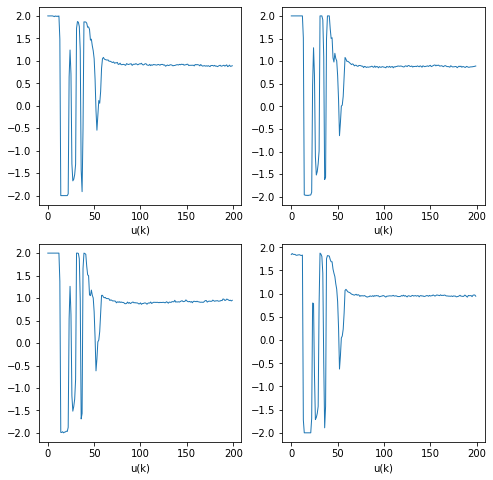

In [10]:
n = 2
fig, axs = plt.subplots(n, n, figsize=(8, 8))
for i, action in enumerate(actions):
    axs[i//n][i%n].plot(np.array(action)[:,0], linewidth=1)
    axs[i//n][i%n].set_xlabel("k")
    axs[i//n][i%n].set_xlabel("u(k)")

plt.show()

Episode 0 finished with reward: -114.10784671407993
Episode 1 finished with reward: -113.77321929917346
Episode 2 finished with reward: -113.91512918071771
Episode 3 finished with reward: -114.57221230335225
Episode 4 finished with reward: -113.5004263102897
Episode 5 finished with reward: -113.54446691553699
Episode 6 finished with reward: -113.42196296800603
Episode 7 finished with reward: -114.42069924129278
Episode 8 finished with reward: -113.34463126024731
Episode 9 finished with reward: -114.12147481072714
Episode 10 finished with reward: -113.6653611259119
Episode 11 finished with reward: -114.07340547579236
Episode 12 finished with reward: -114.97823819163332
Episode 13 finished with reward: -113.21446468232779
Episode 14 finished with reward: -113.96127701261527
Episode 15 finished with reward: -114.41608171328527


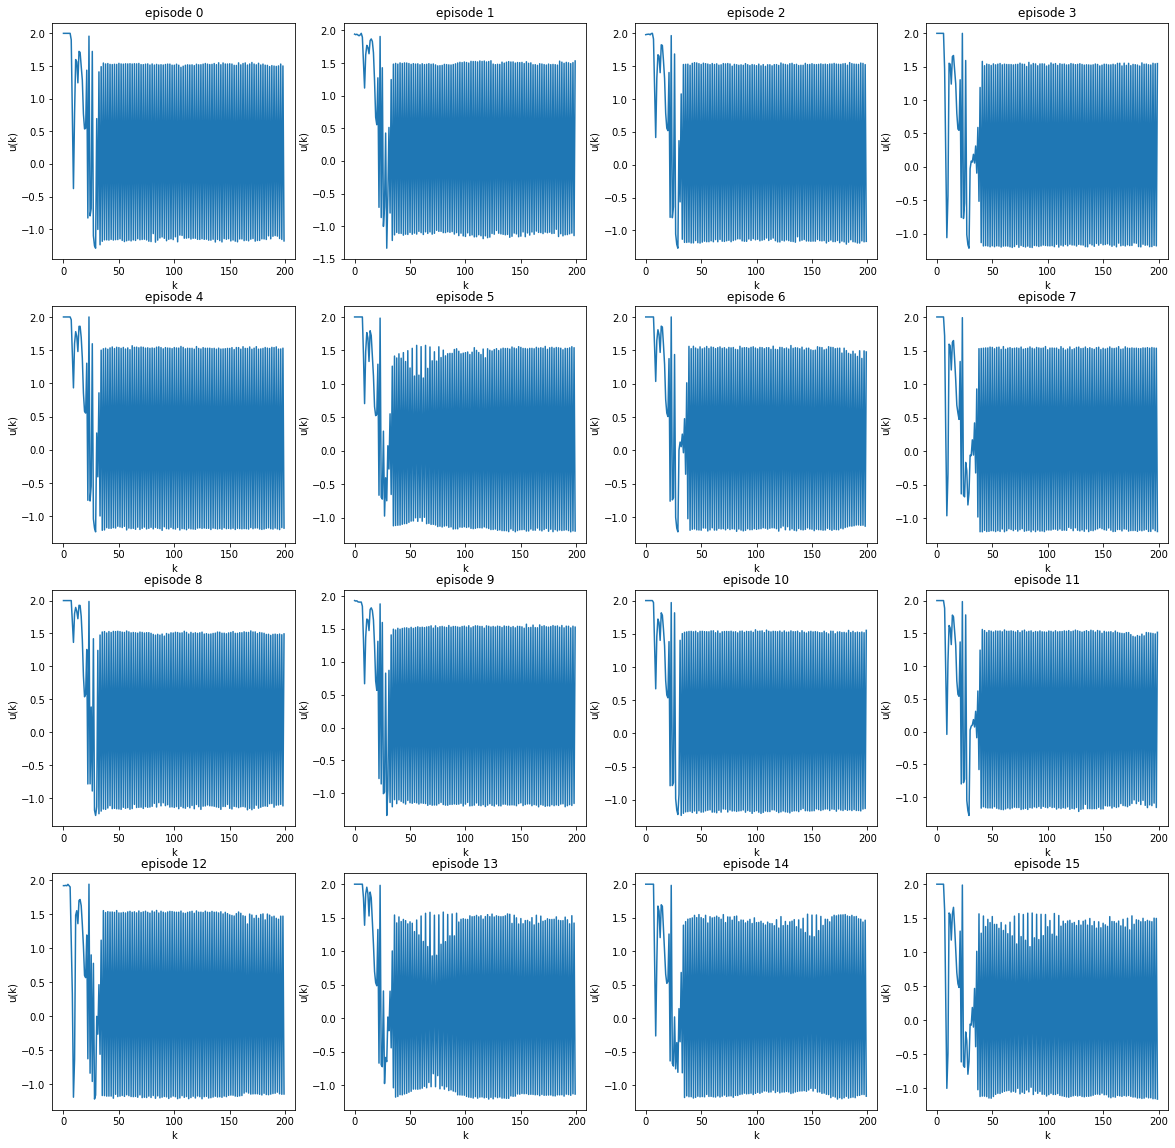

IndexError: index 2 is out of bounds for axis 0 with size 2

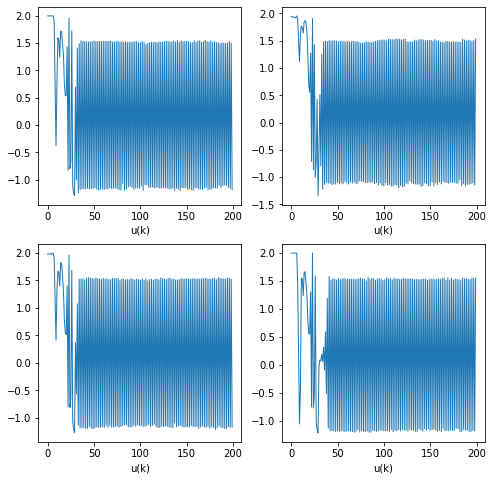

In [13]:
agent.actor = keras.models.load_model("./models/pendulum_actor_16_small_interval.tf")
eps_rewards, observations, actions = play(env, agent, n_games= 16, input_interval=Interval(interval=[[np.pi/2, np.pi/2+0.5], [1, 1]]))
n = 2
fig, axs = plt.subplots(n, n, figsize=(8, 8))
for i, action in enumerate(actions):
    axs[i//n][i%n].plot(np.array(action)[:,0], linewidth=1)
    axs[i//n][i%n].set_xlabel("k")
    axs[i//n][i%n].set_xlabel("u(k)")

plt.show()

In [2]:
# class ExtendedPendulumEnv(PendulumEnv):

#     def reset(self, input_interval = None, return_info: bool = False,):

#         high = np.array([np.pi, 1])

#         if input_interval == None:
#             self.state = self.np_random.uniform(low=-high, high=high)
#         else:
 
#             try:
#                 self.state = self.np_random.uniform(low = input_interval[0], high = input_interval[1])
#             except RuntimeError:
#                 print("Bad shape for input interval, need one dimensional interval object")

#         self.last_u = None
#         if not return_info:
#             return self._get_obs()
#         else:
#             return self._get_obs(), {}

#Will just change that on the files of the module, careful!!
#Recreating the module is not easy, because gym.make won't work that way
#Try to reimplement gym.make?

In [4]:
env = MountainCar
env.reset()
agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16)

In [9]:
#OU noise!!!!
env = Pendulum
env.reset()
agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=64, n_layer2=64, batch_size=64)

In [9]:
print(env.observation_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [4]:
input_interval = Interval(interval=[[-0.6, -0.4], [-0.07, 0.07]])
low, high = input_interval.high_low()
print(f"./models/car_actor{low[0]}_{low[1]}_{high[0]}_{high[1]}.tf")

./models/car_actor-0.6_-0.07_-0.4_0.07.tf


In [ ]:
input_interval = Interval(interval=[[np.pi/2,np.pi/2+0.1], [1, 1+0.1]])
low, high = input_interval.high_low()
train(env, agent, input_interval = input_interval, n_episodes=300)
keras.models.save_model(agent.actor, filepath="./models/pendulum_actor_16_small_interval.tf", save_format="tf")
keras.models.save_model(agent.critic, filepath="./models/pendulum_critic_16_small_interval.tf", save_format="tf")

Episode 0 finished with average reward: -37.53927993774414
Episode 1 finished with average reward: -42.084312438964844
Episode 2 finished with average reward: -40.38857650756836
Episode 3 finished with average reward: -12.26702880859375
Episode 4 finished with average reward: 10.009443283081055
Episode 5 finished with average reward: 24.14337730407715
Episode 6 finished with average reward: 34.66575241088867
Episode 7 finished with average reward: 19.60739517211914
Episode 8 finished with average reward: 28.33119773864746
Episode 9 finished with average reward: 35.00742721557617
Episode 10 finished with average reward: 40.54311752319336
Episode 11 finished with average reward: 43.24102783203125
Episode 12 finished with average reward: 47.352542877197266
Episode 13 finished with average reward: 50.88018035888672
Episode 14 finished with average reward: 53.902854919433594
Episode 15 finished with average reward: 56.71631622314453
Episode 16 finished with average reward: 58.82260894775390

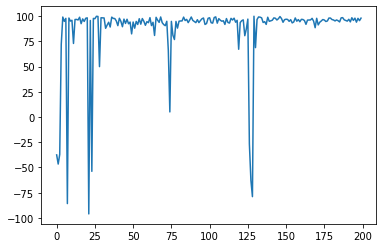

INFO:tensorflow:Assets written to: ./models/car_actor_speed_interval.tf\assets
INFO:tensorflow:Assets written to: ./models/car_critic_speed_interval.tf\assets


In [19]:
input_interval = Interval(interval=[[-0.6, -0.4], [-0.07, 0.07]])
low, high = input_interval.high_low()
train(env, agent, input_interval = Interval(interval=[[-0.6, -0.4], [-0.07, 0.07]]))
keras.models.save_model(agent.actor, filepath="./models/car_actor_speed_interval.tf", save_format="tf")
keras.models.save_model(agent.critic, filepath="./models/car_critic_speed_interval.tf", save_format="tf")

In [66]:
env = MountainCar
env.reset()
agent.actor = keras.models.load_model("./models/car_actor_speed_interval.tf")

In [68]:
env = Pendulum
env.reset()
agent.actor = keras.models.load_model("./models/pendulum_actor_64.tf")

In [100]:
# eps_rewards, observations, actions = play(env, agent, input_interval=Interval(interval=[[-0.54, -0.535], [-0.07, 0.07]]))
eps_rewards, observations, actions = play(env, agent, input_interval=Interval(interval=[[np.pi/2, np.pi/2+0.5], [1, 1]]))

Episode 0 finished with reward: -119.99532823291841
Episode 1 finished with reward: -119.80227283035681
Episode 2 finished with reward: -119.97653075413061
Episode 3 finished with reward: -120.42079538734997
Episode 4 finished with reward: -119.70414251802089
Episode 5 finished with reward: -628.4413128580285
Episode 6 finished with reward: -502.39527020104015
Episode 7 finished with reward: -120.5275820294869
Episode 8 finished with reward: -120.2838900731384
Episode 9 finished with reward: -120.1145998132221


Text(0.5, 0, 'k')

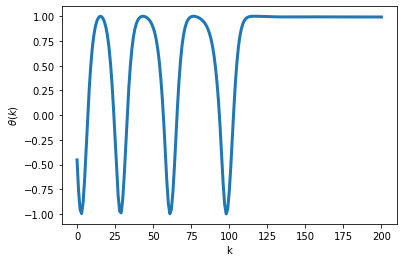

In [83]:
plt.plot(np.array(observations[7])[:, 0], linewidth=3)
plt.ylabel(r"$\theta(k)$")
plt.xlabel("k")

Text(0.5, 0, 'k')

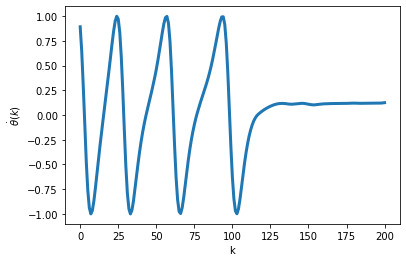

In [82]:
plt.plot(np.array(observations[7])[:, 1], linewidth=3)
plt.ylabel(r"$\dot{\theta}(k)$")
plt.xlabel("k")

Text(0, 0.5, 'u(k)')

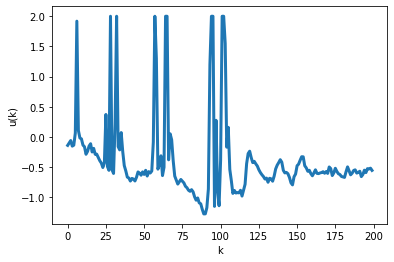

In [77]:
plt.plot(np.array(actions[7])[:, 0], linewidth=3)
plt.xlabel("k")
plt.ylabel("u(k)")

In [6]:
#OU noise!!!!
env = Pendulum
env.reset()
agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=64, n_layer2=64, batch_size=64, noise_std=0.2, epsilon_s=0.05, lambda_smooth=0.2, D_s=10)
input_interval = Interval(interval=[[np.pi/2,np.pi/2+0.1], [1, 1+0.1]])
low, high = input_interval.high_low()
agent.start_training(env, agent, input_interval = input_interval, n_episodes=300)

In [15]:
agent = DDPG(env.observation_space.shape[0], 1, upper_bounds=env.action_space.high, n_layer1=16, n_layer2=16, batch_size=16, noise_std=0.1, epsilon_s=0.05, lambda_smooth=0.2, D_s=10)
agent.actor = keras.models.load_model("./models/car_smooth_actor.tf")

In [16]:
high = env.observation_space.high
low = env.observation_space.low
N = 500

X, Y = np.meshgrid(np.linspace(low[0], high[0], N), np.linspace(low[1], high[1], N))

H = np.concatenate([X.reshape((-1, 1)), Y.reshape(-1, 1)], axis=1)

actions = agent.actor(H)

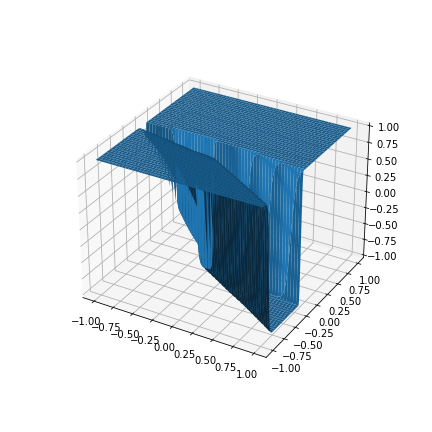

In [20]:
%matplotlib qt
